In [1]:
import torch
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from law import ScalingLaw

def load_loss(path):
    losses = defaultdict(lambda: defaultdict(dict))   # domain -> ratio
    with open(path, "r") as f:
        lines = set(f.readlines())
    for line in lines:   
        model, data, loss = line.split()
        model = model.strip('/')
        step = int(model.split('/')[-1])
        ratio = "-".join(model.split('/')[-2].split('-')[1:])
        subdomain = data.split('/')[-1].split('.')[-2]
        losses[ratio][subdomain][step] = float(loss)
    return losses

LOSSES = {
    "70M": load_loss("data/70M.txt"),
    "160M": load_loss("data/160M.txt"),
}   # sz, ratio, domain, step

In [2]:
ys = dict()
for i in ["70M", "160M"]:
    losses = LOSSES[i]
    ratios = list(losses.keys())
    domains = list(losses[ratios[0]].keys())
    steps = list(losses[ratios[0]][domains[0]].keys())
    ratios = np.sort(ratios)
    ys[i] = defaultdict(lambda:defaultdict(list))
    for r in ratios:
        for d in ["Github", "Pile-CC"]:
            for s in losses[r][d].keys():
                ys[i][d][s].append(losses[r][d][s])

In [3]:
def inter_law(x, param):
    k, b = param
    # y = c + exp(kx+b)
    return torch.exp(k*x + b)

def param_generator():
    for k in np.linspace(-2.4, -1.6, 11):
        for b in np.linspace(-1.0, -0.1, 11):
            yield [k, b]
###


In [4]:
x0 = [float(r.split('-')[0]) for r in ratios]
x1 = [float(r.split('-')[1]) for r in ratios]

In [5]:
params = defaultdict(lambda:defaultdict(lambda:defaultdict(list)))
for m in ["70M", "160M"]:
    for d in domains:
        for s in [10000, 20000, 30000]:
            y = ys[m][d][s]
            x = x0 if d == "Github" else x1
            best_c, max_corr = 0, 0
            for c in np.linspace(0, min(y), 1000):
                corr = np.abs(np.corrcoef(x, np.log(y-c))[0, 1])
                if corr > max_corr:
                    max_corr = corr
                    best_c = c
            law = ScalingLaw(inter_law)
            p = law.fit(x, y-best_c, param_generator(), max_step=100, delta=0.02)
            params[m][d][s] = [best_c, p[0], p[1]] # param
        

/tmp/ipykernel_130051/759608647.py:9: RuntimeWarning: divide by zero encountered in log
  corr = np.abs(np.corrcoef(x, np.log(y-c))[0, 1])
/cpfs01/projects-HDD/cfff-173661e84712_HDD/public/miniconda/envs/sl/lib/python3.11/site-packages/numpy/lib/function_base.py:2742: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:04<00:00, 25.85it/s]


1.0180197932641022e-05 99
tensor([-2.4381, -0.5978])


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:04<00:00, 28.92it/s]


6.930810741323512e-06 99
tensor([-1.5473, -0.6506])


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:04<00:00, 27.34it/s]


3.6705273487314116e-06 99
tensor([-1.6405, -0.6819])


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:03<00:00, 33.36it/s]


9.003677519103803e-07 99
tensor([-2.9041, -0.5333])


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:04<00:00, 27.10it/s]


2.7243918339081574e-06 99
tensor([-2.2959, -0.5862])


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:03<00:00, 31.54it/s]


1.6656942989357049e-06 99
tensor([-2.5189, -0.6257])


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:04<00:00, 27.05it/s]


8.977600373327732e-05 99
tensor([-3.6654, -0.1843])


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:04<00:00, 28.92it/s]


4.9896952987182885e-06 99
tensor([-1.6850, -0.7528])


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:03<00:00, 31.01it/s]


2.7009764380636625e-06 99
tensor([-1.6139, -0.7760])


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:03<00:00, 31.06it/s]


0.0003784890868701041 99
tensor([-0.1236,  1.3070])


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:04<00:00, 27.06it/s]


3.5466832741803955e-06 99
tensor([-2.4178, -0.5877])


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:04<00:00, 24.46it/s]


3.302324785181554e-06 99
tensor([-2.7239, -0.6131])


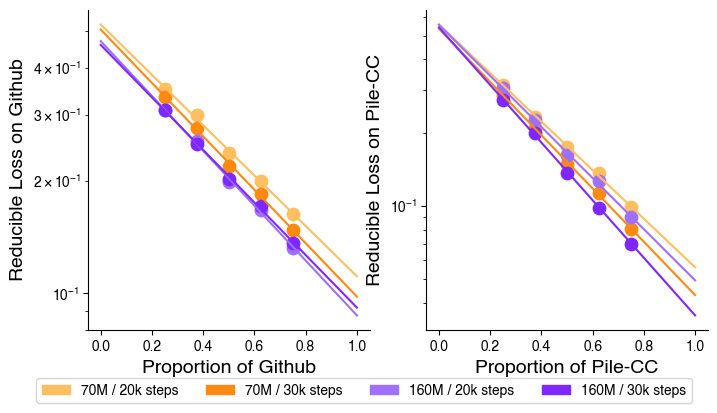

In [49]:
from matplotlib.cm import get_cmap
import matplotlib.patches as mpatches
import matplotlib

plt.rcParams['font.family'] = 'Helvetica'  # Set default font family


c1 = np.array([[253, 191, 96], [255, 137, 17]])/255
c2 = np.array([[159, 112, 253], [127, 39, 255]])/255
c = np.array([c1, c2])

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.subplots_adjust(bottom=0.2, top=1, wspace)

xs = np.linspace(0, 1, 20)

xx = [x0, x1]
for k, d in enumerate(["Github", "Pile-CC"]):
    x = xx[k]
    ax = axes[k]

    for i, m in enumerate(["70M", "160M"]):
        for j, s in enumerate([20000, 30000]):
            y = np.array(ys[m][d][s])
            p = params[m][d][s]
            ax.scatter(x, y-p[0], color=c[i][j], s=80)
            ax.plot(xs, inter_law(torch.tensor(xs), torch.tensor(p[1:])), color=c[i][j])
            ax.set_yscale("log")
            # ax.legend()
            ax.set_xlabel(f"Proportion of {d}", fontsize=14)
            ax.set_ylabel(f"Reducible Loss on {d}", fontsize=14)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
legend_elements = []
for i, m in enumerate(["70M", "160M"]):
    for j, s in enumerate([20000, 30000]):
        el = mpatches.Patch(color=c[i][j], label=f"{m} / {s//1000}k steps")
        legend_elements.append(el)
    
# Create the legend and place it at the bottom of the figure
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.47, 0), ncol=4)
# plt.tight_layout()
plt.savefig('savefigs/2mix.png', dpi=300)